In [2]:
import numpy as np
from PIL import Image
import sys
import os
import cv2

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..",".."))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

# Verify if the parent directory is added
print("Parent directory added to sys.path:", parent_dir)


# Add the parent directory to sys.path
sys.path.append(parent_dir)


from awesome.util.path_tools import get_project_root_path
from awesome.run.functions import plot_as_image, get_mpl_figure, plot_mask

from tqdm.auto import tqdm
from awesome.model.zoo import Zoo
from awesome.model.convex_net import ConvexNextNet
from awesome.run.runner import seed_all
from awesome.util.torch import tensorify
import torch
from matplotlib.colors import get_named_colors_mapping
import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff()
zoo = Zoo()



Parent directory added to sys.path: /Users/kenjileong/Documents/GitHub/awesome


/opt/anaconda3/envs/smu_opt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'WNConvexNextNet' from 'awesome.model.convex_net' (/Users/kenjileong/Documents/GitHub/awesome/awesome/model/convex_net.py)

# How-To: Convexity

This is a simple demonstration, how to use our convexity prior to get a convex segmentation of some unaries.
We used the "sequential" fit as terminology in our manuscript, one can also discribe it as post-processing to some initial segmentation.


Lets consider the following example:

One tries to get a segmentation of a tomato, to calculate e.g. its volume, so occlusions should be included in the segmentation.

In [ ]:
img_dir="data/cocktail-tomatoes.jpg"

def load_image(path: str, down_scale: int = 1) -> np.ndarray:
    img_pil=Image.open(path)
    width, height = img_pil.size 
    newsize = (int(width/down_scale), int(height/down_scale))
    img_pil = img_pil.resize(newsize)

    img= np.array(img_pil, dtype='float')/255.0
    img = img[:,:,0:3]
    nx,ny,nc = img.shape
    return img

img = load_image(img_dir, down_scale=2)

fig = plot_as_image(img, variable_name="Tomato")
fig 

NameError: name 'np' is not defined

First, lets try to get a ruff segmentation, like with a simple thresholding, of course, one can also use any other segmentation method.

# Sigmoid


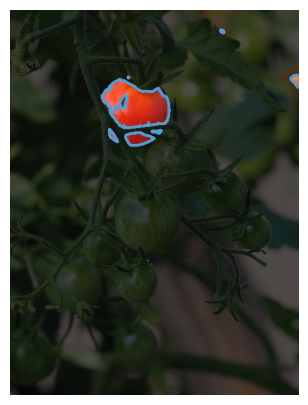

In [ ]:
likelihood = img[:,:,0]-img[:,:,1]-img[:,:,2] - 0.5

likelihood = torch.sigmoid(torch.tensor(1-likelihood).float())
likelihood = likelihood - torch.min(likelihood)
likelihood = likelihood / torch.max(likelihood)
likelihood = (likelihood<0.5).float()
fig = plot_mask(img, likelihood, filled_contours=False, lined_contours=True)
fig

# Softmax Normalization

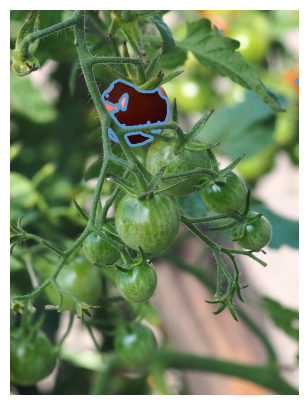

In [ ]:
from scipy.special import softmax

likelihood = img[:, :, 0] - img[:, :, 1] - img[:, :, 2] - 0.5
likelihood = softmax(likelihood.flatten()).reshape(likelihood.shape)
likelihood = likelihood - np.min(likelihood)
likelihood = likelihood / np.max(likelihood)
likelihood = (likelihood < 0.5).astype(float)

fig = plot_mask(img, likelihood, filled_contours=False, lined_contours=True)
fig

# Min-Max Scaling (Simple Normalization)

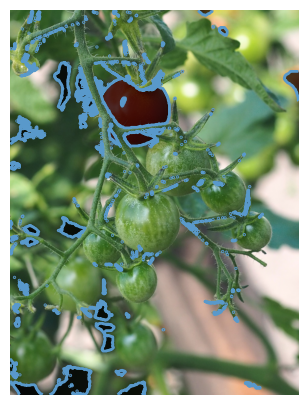

In [ ]:
likelihood = img[:, :, 0] - img[:, :, 1] - img[:, :, 2] - 0.5
likelihood = likelihood - np.min(likelihood)
likelihood = likelihood / np.max(likelihood)
likelihood = (likelihood < 0.5).astype(float)

fig = plot_mask(img, likelihood, filled_contours=False, lined_contours=True)
fig

#  Standardization (Z-score Normalization)

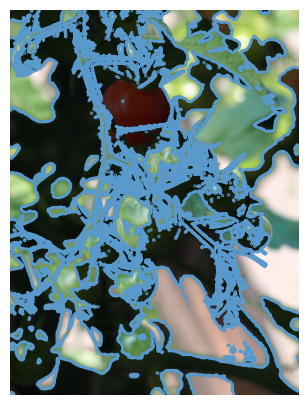

In [ ]:
likelihood = img[:, :, 0] - img[:, :, 1] - img[:, :, 2] - 0.5
mean = np.mean(likelihood)
std = np.std(likelihood)
likelihood = (likelihood - mean) / std
likelihood = (likelihood < 0).astype(float)

fig = plot_mask(img, likelihood, filled_contours=False, lined_contours=True)
fig


In [ ]:

use_cuda = False
# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
height, width = likelihood.shape[-2:]

def get_model_device(model):
    return next(model.parameters()).device

# We need a coordinate grid, which we use to query our implicit representation.
def create_grid(image_shape, device: torch.device):
    ny, nx = image_shape
    x = torch.arange(0, nx, device=device)
    y = torch.arange(0, ny, device=device)
    xx, yy = torch.meshgrid(x, y, indexing='xy')
    grid = torch.stack((xx, yy), dim=0)
    batched_input = grid.unsqueeze(0).float() / torch.tensor([nx, ny], device=device).float().unsqueeze(-1).unsqueeze(-1)
    return batched_input
x = create_grid((height, width), device)

# We define the FG as 0, so we need to invert the mask
unaries = 1 - likelihood.to(device)

seed_all(0)

model = ConvexNextNet(n_hidden_layers=1)
model.to(device)


def plot_loss(loss: torch.Tensor):
    fig, ax = get_mpl_figure(1, 1)
    ax.plot(loss.detach().cpu().numpy())
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training Loss")
    return fig

# Using Adamax as optimizer for the flow net was giving us slightly better results than Adam, but feel free to experiment.
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)  
num_epochs = 100



AttributeError: 'numpy.ndarray' object has no attribute 'to'

Now we can fit the model to the data. This will take a while, so we will only train for 2000 epochs.

Training: 100%|██████████| 100/100 [00:27<00:00,  3.66it/s, loss=0.4] 


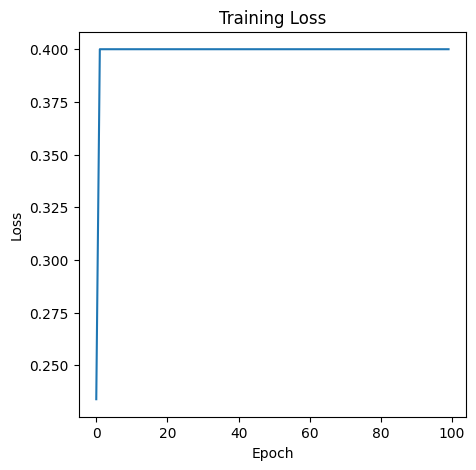

In [ ]:

from awesome.measures.se import SE


def train(
        optimizer: torch.optim.Optimizer, 
        model: ConvexNextNet, 
        unaries: torch.Tensor, 
        num_epochs: int, 
        fg_weight: float = 0.66,
        ):
    # Train the model
    loss_full = torch.zeros(num_epochs, dtype=torch.float32)
    model.train()

    criterion = SE(reduction='none')

    batched_input = create_grid(unaries.shape[-2:], unaries.device)
    it = tqdm(range(num_epochs), total=num_epochs, desc=f"Training")
    batched_unaries = unaries.unsqueeze(0).unsqueeze(0)

    background_mask = batched_unaries == 1.
    foreground_mask = ~background_mask

    bg_length = background_mask.sum()
    fg_length = foreground_mask.sum()

    fg_weight = tensorify(fg_weight, device=unaries.device)

    for epoch in it:
        
        out = torch.sigmoid(model(batched_input))
        if torch.isnan(out).any():
            raise ValueError("Output is nan")

        fg_loss = criterion(out[foreground_mask], batched_unaries[foreground_mask])
        bg_loss = criterion(out[background_mask], batched_unaries[background_mask])

        # We are weighting the fg and bg differently to get proper tomato segmentation
        loss = (1 - fg_weight) * (bg_loss.sum() / bg_length) + (fg_weight * (fg_loss.sum() / fg_length))

        loss_full[epoch] = loss.detach().cpu()
            
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # After Each epoch we enforce the convexity of the convex net to ensure the convexity of the model => Weights should be positive
        model.enforce_convexity()

        if (epoch+1) % 50 == 0 or epoch == 0:
            it.set_postfix({'loss': loss.item()})
            
    return model, loss_full

tm, loss = train(optimizer, model, unaries, num_epochs, fg_weight=0.4)
fig = plot_loss(loss)
fig

With the trained model, we can now inference and get the segmentation of the tomato.

In [ ]:
model.eval()
with torch.no_grad():
    # We query the model with a grid of coordinates. The model will return the likelihood of each pixel being foreground.
    # We can also create a super resolution grid to get a higher resolution output.
    in_ = create_grid(unaries.shape[-2:], unaries.device).to(get_model_device(model))
    path_connected_likelihood = model(in_).squeeze().cpu()

# We can now threshold the output to get a binary mask.
path_connected_likelihood_mask = torch.sigmoid(path_connected_likelihood) < 0.5


## Voila! We have a *provable* convex segmentation of the tomato!

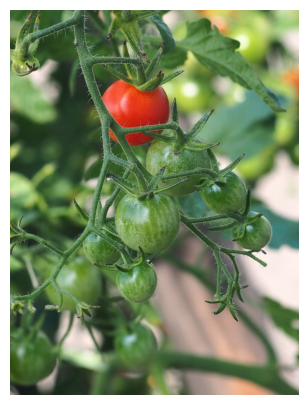

In [ ]:
color = get_named_colors_mapping().get("tab:orange")
plot_mask(img, path_connected_likelihood_mask, color=color, variable_name="Output of the model")